# 遅延演算

In [1]:
import polars as pl
import numpy as np
import threading
from helper.jupyter import row

Polarsの遅延演算は、クエリを即時実行せず「実行計画」として蓄積し、最適化後に一括実行する仕組みです。主なメリットは以下です。

- **自動最適化**: 不要な計算の省略・操作順序の最適化
- **メモリ効率**: 必要なタイミングでのみ処理実行
- **大規模データ対応**: メモリ不足のリスク低減

## 基本フロー  

1. `DataFrame.lazy()` メソッドで `LazyFrame` に変換するか、`scan_*()` 関数で直接ファイルから `LazyFrame` を取得します。  
2. フィルタや集計などの処理チェーンを構築します。  
3. `collect()` で最終実行するか、`explain()`や`show_graph()` で実行計画を確認します。  

以下の例では、`df.lazy()` で `LazyFrame` に変換した後、`DataFrame` と同じメソッドを使って処理チェーンを構築します。  

In [4]:
df = pl.DataFrame({
    "product": ["A", "B", "C", "A", "B"],
    "category": ["X", "Y", "X", "Y", "X"],
    "price": [100, 200, 150, 300, 250],
    "quantity": [5, 3, 4, 2, 6]
})

lazy_operations = (
    df.lazy()
    .filter(pl.col("price") > 150)
    .filter(pl.col("price") < 280)
    .group_by("category")
    .agg(pl.col("quantity").sum().alias("total_quantity"))
)

`show_graph()` を使うと、実行計画を分析できます。`optimized` 引数を `True` にすると最適化後の計画を確認できます。以下の出力例のように、最適化後は 2 つの `FILTER` が 1 つの `SELECTION` に統合されます。  

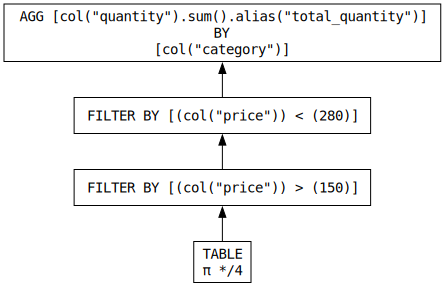

In [5]:
lazy_operations.show_graph(optimized=False)

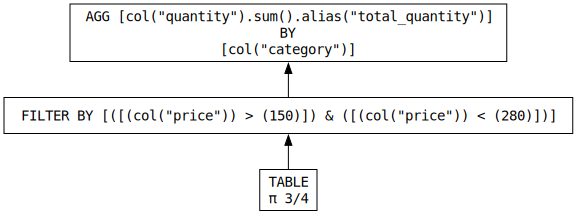

In [7]:
lazy_operations.show_graph(optimized=True)

演算結果を取得するには `collect()` メソッドを使用します。  

In [8]:
lazy_operations.collect()

category,total_quantity
str,i64
"""X""",6
"""Y""",3


`collect()` 実行後も処理チェーンは保持されるため、`sort()` を追加して再実行することもできます。  

In [9]:
lazy_operations.sort("total_quantity", descending=True).collect()

category,total_quantity
str,i64
"""X""",6
"""Y""",3


次のテーブルで、遅延演算と即時実行の比較をまとめます。

| 特徴                | 遅延演算 (Lazy)       | 即時実行 (Eager)       |
|---------------------|-----------------------|------------------------|
| 実行タイミング       | `collect()` で一括実行 | 各操作ごとに即時実行   |
| 最適化              | 自動的に実施          | なし                   |
| メモリ効率          | 高い                  | 低い（中間データ保持） |
| 主な用途            | 大規模データ・複雑処理 | 小規模データ・簡易処理 |


## ストリーミング処理


Polarsのストリーミング処理は、大規模なデータセットを効率的に処理するための仕組みで、データを「チャンク」と呼ばれる小さな部分に分割し、逐次処理を行います。この手法により、メモリ消費を抑えながら高速なデータ処理が可能です。

In [11]:
n = 1000
df = pl.LazyFrame({
    "A": np.random.randn(n),
    "B": np.random.randn(n),
    "C": np.random.randint(0, 10, n)
})

演算をストリーミングで処理できるか確認するには、`.show_graph(engine="streaming", plan_stage="physical")` を使用します。
出力されるグラフでは、**白いノードはストリーミング処理が可能な演算**を、**黄色のノードはストリーミング処理は可能だがメモリ使用量が多くなる可能性のある演算**を示します。

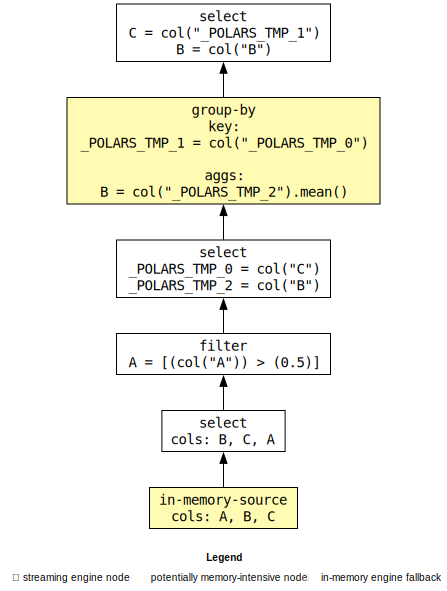

In [12]:
df2 = df.filter(pl.col('A') > 0.5).group_by('C').agg(pl.col('B').mean())
df2.show_graph(engine="streaming", plan_stage="physical")

`group_by()` に `maintain_order=True` を設定した場合、`group_by()` 演算ノードは赤色で表示され、ストリーミング処理が不可能となります。この場合、処理は `"in-memory"` エンジンで実行されます。

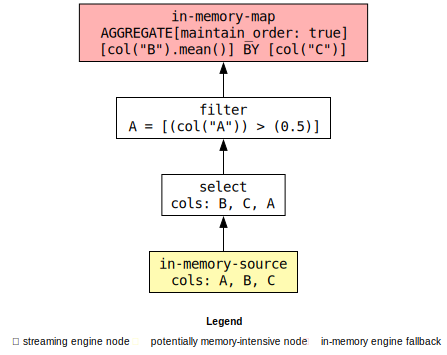

In [13]:
df3 = df.filter(pl.col('A') > 0.5).group_by('C', maintain_order=True).agg(pl.col('B').mean())
df3.show_graph(engine="streaming", plan_stage="physical")

ストリーミング処理を使って結果を計算する場合、`.collect(engine="streaming")`を呼び出します。この方法では、可能であればストリーミング処理が適用され、効率的に結果を計算します。

In [14]:
row(df2.collect(engine="streaming"), df3.collect(engine="streaming"))

C,B
i32,f64
8,0.499383
5,0.014106
1,-0.050324
2,0.080897
6,-0.328389
3,-0.350192
7,0.249191
0,0.149951
9,-0.077746


## UDFでストリーミングを観察

ストリーミング処理を観察するには、`map_batches()` や `map_element()` などのユーザー定義関数 (UDF: User-Defined Function)を利用できます。ユーザー関数内でデータの長さや処理中のスレッドを出力することで、ストリーミング処理における分割や並列処理を直接観察できます。

### `Expr.map_batches`

次のコードでは以下を行っています：

* 複数のスレッドからの出力が混在しないように、`threading.Lock()` を使用しています。
* `map_batches()` の `is_elementwise` 引数を `True` に設定し、分割と並列処理を有効にしています。

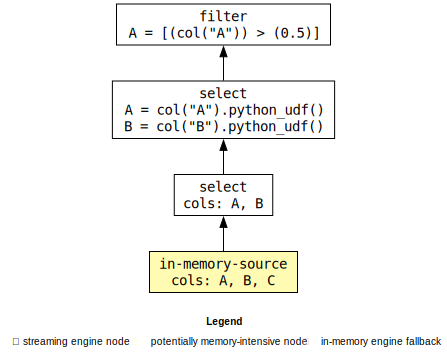

In [17]:
lock = threading.Lock()
def f(s):
    with lock:
        print(s.name, s.shape, threading.current_thread())
        return s

df4 = (
    df
    .select(
        pl.col('A', 'B').map_batches(f, return_dtype=pl.self_dtype(), is_elementwise=True)
    )
    .filter(pl.col('A') > 0.5)
)
df4.show_graph(engine="streaming", plan_stage="physical")

`collect(engine="streaming")`実行すると、以下のような出力から、A列とB列がそれぞれ長さ125のチャンクに分割され、異なるスレッドで並列処理されていることが確認できます。

In [18]:
df4.collect(engine="streaming");

A (125,) <_DummyThread(Dummy-9, started daemon 9008)>
A (125,) <_DummyThread(Dummy-10, started daemon 11520)>
A (125,) <_DummyThread(Dummy-11, started daemon 19448)>
A (125,) <_DummyThread(Dummy-12, started daemon 14368)>
A (125,) <_DummyThread(Dummy-13, started daemon 6584)>
A (125,) <_DummyThread(Dummy-14, started daemon 10912)>
B (125,) <_DummyThread(Dummy-13, started daemon 6584)>
B (125,) <_DummyThread(Dummy-9, started daemon 9008)>
B (125,) <_DummyThread(Dummy-10, started daemon 11520)>
B (125,) <_DummyThread(Dummy-12, started daemon 14368)>
B (125,) <_DummyThread(Dummy-11, started daemon 19448)>
A (125,) <_DummyThread(Dummy-15, started daemon 3192)>
B (125,) <_DummyThread(Dummy-14, started daemon 10912)>
A (125,) <_DummyThread(Dummy-16, started daemon 13200)>
B (125,) <_DummyThread(Dummy-13, started daemon 6584)>
B (125,) <_DummyThread(Dummy-9, started daemon 9008)>


また、`in-memory`エンジンを使用する場合、A列とB列はチャンクに分割されず、それぞれ全体を別々のスレッドで処理することがわかります。

In [19]:
df4.collect(engine="in-memory");

A (1000,) <_DummyThread(Dummy-17, started daemon 12128)>
B (1000,) <_DummyThread(Dummy-18, started daemon 1172)>


`scan_*()`関数を使用してファイルからデータを読み込んで処理する場合、事前にデータの長さがわからないため、次のコードの出力からも分かるように、チャンクを均等に分割することができません。

In [22]:
df.collect().write_csv('data/streaming_test.csv')
df5 = (
    pl
    .scan_csv('data/streaming_test.csv', cache=False, )
    .select(
        pl.col('A', 'B').map_batches(f, return_dtype=pl.self_dtype(), is_elementwise=True)
    )
    .filter(pl.col('A') > 0.5)
)
df5.collect(engine="streaming");

A (99,) <_DummyThread(Dummy-27, started daemon 1060)>
A (99,) <_DummyThread(Dummy-28, started daemon 10048)>
A (99,) <_DummyThread(Dummy-29, started daemon 6640)>
A (99,) <_DummyThread(Dummy-30, started daemon 11220)>
A (99,) <_DummyThread(Dummy-31, started daemon 3560)>
A (99,) <_DummyThread(Dummy-32, started daemon 18252)>
A (99,) <_DummyThread(Dummy-33, started daemon 17372)>
B (99,) <_DummyThread(Dummy-27, started daemon 1060)>
B (99,) <_DummyThread(Dummy-28, started daemon 10048)>
B (99,) <_DummyThread(Dummy-29, started daemon 6640)>
B (99,) <_DummyThread(Dummy-30, started daemon 11220)>
B (99,) <_DummyThread(Dummy-31, started daemon 3560)>
B (99,) <_DummyThread(Dummy-32, started daemon 18252)>
B (99,) <_DummyThread(Dummy-33, started daemon 17372)>
A (99,) <_DummyThread(Dummy-34, started daemon 18328)>
A (99,) <_DummyThread(Dummy-27, started daemon 1060)>
A (10,) <_DummyThread(Dummy-28, started daemon 10048)>
A (99,) <_DummyThread(Dummy-29, started daemon 6640)>
B (99,) <_DummyThr

### `LazyFrame.map_batches`

`LazyFrame` の `map_batches()` メソッドもストリーミング処理をサポートしています。有効にするには、`streamable` 引数を `True` に設定します。この場合、元のデータはチャンクに分割され、それぞれのチャンクが `DataFrame` オブジェクトとして UDF に渡されます。

In [25]:
lock = threading.Lock()
def f(df):
    with lock:
        print(type(df).__name__, df.shape, threading.current_thread())
        return df

df2 = df.map_batches(f, streamable=True)
df2.collect(engine="streaming");

DataFrame (125, 3) <_DummyThread(Dummy-35, started daemon 2580)>
DataFrame (125, 3) <_DummyThread(Dummy-38, started daemon 13744)>
DataFrame (125, 3) <_DummyThread(Dummy-39, started daemon 11508)>
DataFrame (125, 3) <_DummyThread(Dummy-40, started daemon 13792)>
DataFrame (125, 3) <_DummyThread(Dummy-41, started daemon 13700)>
DataFrame (125, 3) <_DummyThread(Dummy-42, started daemon 14316)>
DataFrame (125, 3) <_DummyThread(Dummy-36, started daemon 8640)>
DataFrame (125, 3) <_DummyThread(Dummy-37, started daemon 8172)>


### `Expr.map_elements`

`map_elements()` は個々の値を UDF に渡し、その結果を収集します。ストリーミングエンジンを使用する場合、演算は複数のスレッドで並行して実行されます。

In [26]:
lock = threading.Lock()
def f(val):
    with lock:
        print(val, threading.current_thread())
        return val

n = 10

df = pl.LazyFrame({
    "A": np.random.randn(n),
    "B": np.random.randn(n),
    "C": np.random.randint(0, 10, n)
})
        
df2 = df.select(
    pl.col('A', 'B').map_elements(f, return_dtype=pl.self_dtype())
)

In [27]:
df2.collect(engine="streaming");

-1.108559246221127 <_DummyThread(Dummy-43, started daemon 11236)>
-1.4996460924229866 <_DummyThread(Dummy-43, started daemon 11236)>
-1.1117041500948521 <_DummyThread(Dummy-44, started daemon 9144)>
1.328385724900826 <_DummyThread(Dummy-44, started daemon 9144)>
-1.4112473238996046 <_DummyThread(Dummy-45, started daemon 11784)>
-1.5267976124012157 <_DummyThread(Dummy-45, started daemon 11784)>
2.047594932686955 <_DummyThread(Dummy-46, started daemon 7056)>
-0.8682594885868978 <_DummyThread(Dummy-46, started daemon 7056)>
-0.6480673772761889 <_DummyThread(Dummy-47, started daemon 11728)>
0.5322035399347776 <_DummyThread(Dummy-47, started daemon 11728)>
0.7861824044589285 <_DummyThread(Dummy-47, started daemon 11728)>
0.8684617127999552 <_DummyThread(Dummy-47, started daemon 11728)>
0.3307972073348304 <_DummyThread(Dummy-45, started daemon 11784)>
-0.15309985371146326 <_DummyThread(Dummy-45, started daemon 11784)>
0.4025427281690959 <_DummyThread(Dummy-46, started daemon 7056)>
-0.381560

In [29]:
df2.collect(engine="in-memory");

-1.1117041500948521 <_DummyThread(Dummy-17, started daemon 12128)>
1.328385724900826 <_DummyThread(Dummy-17, started daemon 12128)>
-1.4112473238996046 <_DummyThread(Dummy-17, started daemon 12128)>
-1.5267976124012157 <_DummyThread(Dummy-17, started daemon 12128)>
-1.108559246221127 <_DummyThread(Dummy-17, started daemon 12128)>
-1.4996460924229866 <_DummyThread(Dummy-17, started daemon 12128)>
2.047594932686955 <_DummyThread(Dummy-17, started daemon 12128)>
-0.8682594885868978 <_DummyThread(Dummy-17, started daemon 12128)>
-0.6480673772761889 <_DummyThread(Dummy-17, started daemon 12128)>
0.5322035399347776 <_DummyThread(Dummy-17, started daemon 12128)>
0.16564419733378172 <_DummyThread(Dummy-18, started daemon 1172)>
2.363639375538098 <_DummyThread(Dummy-18, started daemon 1172)>
0.3307972073348304 <_DummyThread(Dummy-18, started daemon 1172)>
-0.15309985371146326 <_DummyThread(Dummy-18, started daemon 1172)>
-0.5081061234693295 <_DummyThread(Dummy-18, started daemon 1172)>
-0.09762